In [1]:
import pandas

dataset = pandas.read_table("ICPSR_37692/DS0001/37692-0001-Data.tsv", low_memory=False)

In [2]:
def remove_indet(frame, variable_name, keep_dontknow=False, dontknow_signal="-1"):
    ''' 
    Removes entries from the dataframe for which the given variables has a negative, indeterminate value.
    When keep_dontknow is true, it preserves entries for which the value was "-1", which is used in the data as a generic
    "don't know" signal. That operation does not preserve order.
    '''
    neg_mask = frame[f'{variable_name}'].str[0] == "-"
    if keep_dontknow:
        frame1 = frame.query('not @neg_mask')
        frame2 = frame.query(f'{variable_name} == "{dontknow_signal}"')
        frame = pandas.concat([frame1, frame2])
    else:
        frame = frame.query('not @neg_mask')

    return frame
    

In [3]:
'''Select only self-identified transgender people.'''

trans_data = dataset.query('V1212 == "3"')

First, we will cut the data into sets for specific interest groups.

In [4]:
'''
Select only data on non-straight people. This excludes V1213 answer 2, 
and also people who failed to indicate sexual orientation.

I include people who reported that they did not know their sexual orientation,
either via the -1 "Don't Know" error coding or the 5 "You don't know the answer."
This should allow for questioning people to be included as well.
'''

lgbq_data = dataset.query('V1213 != "2"') 
lgbq_data = remove_indet(lgbq_data, "V1213", keep_dontknow=True)

In [5]:
'''
Select 'assigned gender non-conforming' people. I define this to mean people whose assigned sex at birth does not match
their gender, regardless of transgender identification.
'''

agnc_data = dataset.query('V1211 != V1212')
agnc_data = remove_indet(agnc_data, 'V1211')
agnc_data = remove_indet(agnc_data, 'V1212', keep_dontknow=True)

In [6]:
print(len(dataset))
print(len(trans_data))
print(len(lgbq_data))
print(len(agnc_data))


24848
31
2139
95


In [7]:
print(len(lgbq_data.query('V1213 == "3"')))

1183


In [26]:
''' Interestingly, only about 1 in 3 ASNC people in this population chose to label themselves transgender. '''
len(trans_data)/len(agnc_data)

0.3263157894736842

In [9]:
''' Merge into a dataset for all lgbtq people. '''

lgbtq_data = pandas.concat([lgbq_data, agnc_data]).drop_duplicates()
len(lgbtq_data)

2169

In [27]:
''' Total LGBTQ rate was 8.7%, markedly higher than the US rate (~3.7%). '''
len(lgbtq_data) / len(dataset)

0.08729072762395364

In [24]:
''' 
71% of LGBTQ respondants identified as female, but only 
25% of the total population did. 
'''

m = len(lgbtq_data.query("V1212 == '1'"))
f = len(lgbtq_data.query("V1212 == '2'"))
print(m)
print(f)
print(f / (m+f))

m = len(dataset.query("V1212 == '1'"))
f = len(dataset.query("V1212 == '2'"))
print(m)
print(f)
print(f / (m+f))

561
1401
0.7140672782874617
18402
6234
0.2530443253774963


Seperate these datasets by state.

In [11]:
''' A list of all state codes given by the dataset. Invalid codes are removed. '''
list_state_codes = ['FL', 'MD', 'PA', 'NM', 'KY', 'MA', 'OR', 'WV', 'WI', 'WA', 'MI', 'CA', 'IL', 'VA', 'DE', 'NY', 'NV', 'SD', 'LA', 'UT', 'TX', 'MN', 'MO', 'SC', 'GA', 'NC', 'TN', 'IA', 'OH', 'IN', 'CT', 'MS', 'AR', 'HI', 'OK', 'NJ', 'ID', 'AZ', 'VT', 'NE', 'CO', 'AK', 'AL', 'KS', 'ND', 'RI', 'NH', 'WY', 'MT', 'ME']
# PR, DC removed because of data issues

In [12]:
def cut_by_state(frame):
    ''' Divide a dataframe into a dictionary of 50 dataframes by state the inmate was living in at the time of arrest. '''
    statewise_dict = {}
    for state in list_state_codes:
        subset = frame.query(f'V0772 == "{state}"')
        statewise_dict[state] = subset
        
    return statewise_dict
        

In [13]:
lgbtq_bs = cut_by_state(lgbtq_data)

Calculate the LGBTQ overrepresentation index for each state.

The OverRepresetnation Ratio is meant to measure how much more likely an LGBTQ person is to be incarcerated in a given
state than a member of the general population. It's made of the following factors:

In [14]:
''' Read in data needed for the ORR '''

state_lgbt = pandas.read_csv("pop_counts/lbgt_percent_by_state.csv")

state_pops = pandas.read_csv("pop_counts/state_pops.csv")

state_incs = pandas.read_csv("pop_counts/total_incarcerated_by_state.csv")

In [44]:
'''OverRepresentation Ratio, measures proportion of 
LGBTQ prisoners in sample to ordinary prisoners.

Note that these values are unweighted, and so must be used with care. 

a - number self-reported lgbtq people in sample in state
N - number sampled in state
L - estimated proportion lgbtq in state

o = (a/N) / L

'''

orr_bs = {}
vars_bs = {}

sample_min = 20

for state in list_state_codes:
    a = len(lgbtq_bs[state])
    L = float(state_lgbt.query(f'State == "{state}"')['Estimated Percent LGBT']) / 100
    I = int(state_incs.query(f'State == "{state}"')['Incarcerated'])
    #P = int(state_pops.query(f'Label == "{state}"')['Total'])
    N = len(dataset.query(f'V0772 == "{state}"'))
    
    if N < sample_min or a == 0:
        a = 0
    else:
        vars_bs[f'{state}'] = [(a/N), L, ((a/N) / L),(N/I)]
    
    orr_bs[f'{state}'] = (a/N) / L
    

In [45]:
for state in sorted(orr_bs, key=orr_bs.get, reverse=True):
    print(f"{state}: {orr_bs[state]}")
        


ID: 11.818783070792263
UT: 8.262886596659461
KY: 7.33661740578609
WV: 5.920297336100449
NE: 5.860606061281628
MN: 5.755102041618753
SD: 5.604999999131225
AR: 5.140549449971653
AK: 4.899733510570392
NM: 4.878807106385537
SC: 4.816429490842986
OK: 4.6825992997561885
NJ: 4.516358669737267
WI: 4.327075534432707
IN: 4.245109012386153
KS: 3.7897757715578564
DE: 3.7427667269292386
WY: 3.735483871154516
LA: 3.731302990048621
HI: 3.5254120880856465
CT: 3.495740638685962
VA: 3.467625969602179
TN: 3.3067930265482537
NC: 3.254395875011212
AL: 3.207194742322028
IA: 3.0538415000321977
MD: 2.894999657893661
OH: 2.8563539150795036
MS: 2.7123037979517624
MO: 2.6400565391508115
WA: 2.3770345594820133
AZ: 2.3233923983993914
GA: 2.312064459992402
OR: 2.284758400053061
NV: 2.2614375777440907
MA: 2.250849007199595
PA: 2.131936399334565
TX: 2.026218693797344
IL: 1.8647944289927614
CO: 1.814810924502501
NY: 1.7498306877690062
MI: 1.720314653049697
MT: 1.6496913580989274
CA: 1.56012742836835
FL: 1.445043693526

In [49]:
rep_plot_frame = pandas.DataFrame.from_dict(vars_bs, orient='index', columns = ['incar', 'general', 'orr', 'rratio'])

<AxesSubplot:>

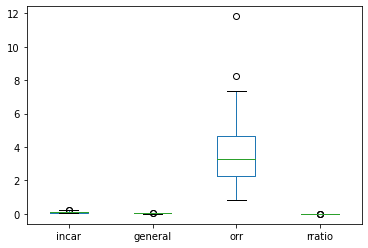

In [50]:
rep_plot_frame.plot.box()

<AxesSubplot:xlabel='general', ylabel='incar'>

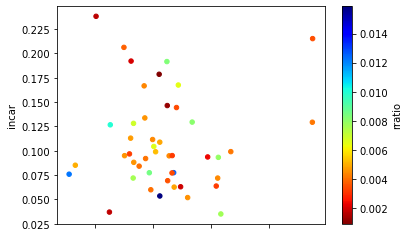

In [51]:
rep_plot_frame.plot.scatter(x='general', y='incar', c='rratio', colormap='jet_r')

In [52]:
print(rep_plot_frame.sort_values('orr',axis='index'))
print(rep_plot_frame.median())

       incar   general        orr    rratio
VT  0.035088  0.041667   0.842105  0.007703
FL  0.051940  0.035944   1.445044  0.004577
CA  0.063768  0.040874   1.560127  0.003218
MT  0.037037  0.022451   1.649691  0.001776
MI  0.053571  0.031140   1.720315  0.015858
NY  0.071958  0.041123   1.749831  0.004455
CO  0.063025  0.034728   1.814811  0.001952
IL  0.062690  0.033617   1.864794  0.004843
TX  0.059956  0.029590   2.026219  0.004036
PA  0.069277  0.032495   2.131936  0.003608
MA  0.129310  0.057450   2.250849  0.004198
NV  0.093248  0.041234   2.261438  0.007934
OR  0.099125  0.043385   2.284758  0.004183
GA  0.077526  0.033531   2.312064  0.012560
AZ  0.077244  0.033246   2.323392  0.003484
WA  0.093645  0.039396   2.377035  0.002354
MO  0.077434  0.029330   2.640057  0.008536
MS  0.072000  0.026546   2.712304  0.007657
OH  0.095057  0.033279   2.856354  0.003225
MD  0.094808  0.032749   2.895000  0.004475
IA  0.084211  0.027575   3.053842  0.004069
AL  0.092010  0.028689   3.20719

In [34]:
''' Isolate the interquartile range. '''
q1 = rep_plot_frame.quantile(.25)
q3 = rep_plot_frame.quantile(.75)
print("Removing: ")
for item in rep_plot_frame.index:
    if rep_plot_frame.at[item, 'orr'] > q3['orr'] or rep_plot_frame.at[item, 'orr'] < q1['orr']:
        print(item)
        rep_plot_frame.at[item] = None

Removing: 
FL
PA
NM
KY
MA
WV
MI
CA
IL
NY
NV
SD
UT
TX
MN
SC
AR
OK
ID
VT
NE
CO
AK
MT


<AxesSubplot:xlabel='general', ylabel='incar'>

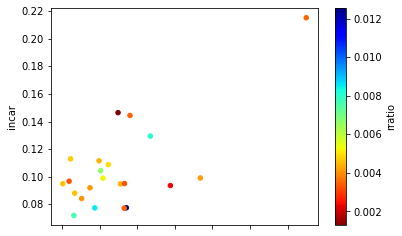

In [35]:
rep_plot_frame.plot.scatter(x='general', y='incar', c='rratio', colormap='jet_r')

In [36]:
rep_plot_frame.sort_values('orr',axis='index')

,incar,general,orr,rratio
OR,0.099125,0.043385,2.284758,0.004183
GA,0.077526,0.033531,2.312064,0.012560
AZ,0.077244,0.033246,2.323392,0.003484
WA,0.093645,0.039396,2.377035,0.002354
MO,0.077434,0.029330,2.640057,0.008536
MS,0.072000,0.026546,2.712304,0.007657
OH,0.095057,0.033279,2.856354,0.003225
MD,0.094808,0.032749,2.895000,0.004475
IA,0.084211,0.027575,3.053842,0.004069
AL,0.092010,0.028689,3.207195,0.004138
